In [25]:
import pandas as pd
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
import numpy as np
import math
import os

In [26]:
axis_info = list()

# original alignment
axis_info.append({"x_col": "Novel Junctions", "y_col":"Reference Junctions", \
    "xlabel": r'Novel Junctions ($\times10^{3}$)', "ylabel": r'Reference Junctions ($\times10^{3}$)', \
    "data_group": "original", "color": "black", "marker": 'o'}
    )

axis_info.append({"x_col": "EASTR Novel Junctions", "y_col": "EASTR Reference Junctions", \
    "xlabel": r'Novel Junctions ($\times10^{3}$)', "ylabel": r'Reference Junctions ($\times10^{3}$)', \
    "data_group": "EASTR", "color": "red", "marker": '^'}
    )
# EASTR alignment
group_col = "Aligner"

out_basedir = "/ccb/salz8-3/rhu16/EASTR/EASTR_analyses/junction_plots"

# plot specs
scale_x = 1000
scale_y = 1000
#color_groups = treatments
#colors = ["black", "red"]
#marker_groups = ["hisat", "star"]
#marker_labels = ["HISAT2", "STAR"]
#markers = ["o", "^"]

In [27]:
dataset = "lieber_sra"

junction_file = os.path.join("/ccb/salz2/shinder/projects/EASTR_tests2", dataset, "eastr_juncs_alns_summary.tsv")
outdir = os.path.join(out_basedir, dataset)

info_list = list()
info_list.append({"targets": ["SRR10689481","SRR10689483","SRR10689487"], "target_labels": ["SRR10689481","SRR10689483","SRR10689487"], "comparison": "riboZ", "title": "Prenatal DLPFC: poly(A)"})
info_list.append({"targets": ["SRR10689480","SRR10689482","SRR10689486"], "target_labels": ["SRR10689480","SRR10689482","SRR10689486"], "comparison": "polyA", "title": "Prenatal DLPFC: ribo-minus"})

In [28]:
junction_stats = pd.read_csv(junction_file, sep='\t')
junction_stats["EASTR Reference Junctions"] = junction_stats["Reference Junctions"] - junction_stats["Removed Reference Junctions"]
junction_stats["EASTR Novel Junctions"] = junction_stats["Novel Junctions"] - junction_stats["Removed Novel Junctions"]
junction_stats["sampleID"] = junction_stats["SRR ID"]

In [29]:
def match_group(treatment_str=str, groups=list()):
    found = False
    match_idx = None
    for i in range(0, len(groups)):
        if treatment_str.find(groups[i]) >= 0:
            if found:
                raise Exception("more than one group matched by this string-finding function")
            found = True
            match_idx = i
    return match_idx

def baseround(x, base=1):
    return int(base * round(float(x)/base))

def basefloor(x, base=1):
    return base * math.floor(float(x)/base)

def baseceil(x, base=1):
    return base * math.ceil(float(x)/base)

def space_labels(vals, tick_len, min_val=0, margin_count=1):
    return np.arange(max(basefloor(min(vals), base=tick_len) - tick_len*margin_count, 0), baseceil(max(vals), base=tick_len) + tick_len*margin_count, tick_len)

def space_whole_labels(values, tick_magnitude=5, ticks=5, pad_factor=0):
    diff = ( max(values) - min(values) )
    pad = diff*pad_factor
    #width = pad + diff + pad # left pad + difference between min, max + right pad
    tick_spacing = max(baseround(diff/ticks, base=tick_magnitude), tick_magnitude)

    # leftmost and rightmost grid (floor to left align, making it closer to the origin if necessary)
    leftmost = basefloor( min(values) - pad, base=tick_magnitude) #- tick_magnitude
    rightmost = baseceil( max(values) + pad, base=tick_magnitude) + tick_spacing
    
    #print(leftmost)
    #print(np.arange(math.floor(min(values) - pad)-1, math.ceil(max(values) + pad)+1, tick_spacing))
    return np.arange(leftmost, rightmost, tick_spacing)

def subplot_targets(stats_df, info, axis_info):
    targets = info["targets"]
    target_labels = info["target_labels"]
    title = info["title"]

    # get counts for reference-matching and novel junctions
    fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(40, 8),gridspec_kw={'wspace':0.1,'hspace':0.2})
    

    # plot each sample, for all treatments
    plots = list()

    axes_idx = 0
    for i in range(0, len(targets)):
        sampleID = targets[i]
        sampleLabel = target_labels[i]
        #print(sample + "__________")
        #plt.figure(figsize=(10, 8), dpi=80)
        x_vals = list() # all x
        y_vals = list() # all y
        sample_stats = stats_df.loc[stats_df["sampleID"] == sampleID]
        for idx in range(0, len(sample_stats)):
            sample_stat = sample_stats.iloc[[idx]]
            for axis_idx in range(0, len(axis_info)):
                x_val = sample_stat[axis_info[axis_idx]["x_col"]].values/scale_x
                x_vals.append(x_val)
                y_val = sample_stat[axis_info[axis_idx]["y_col"]].values/scale_y
                y_vals.append(y_val)
                axes[axes_idx].scatter(x_val, y_val, \
                    color=axis_info[axis_idx]["color"], marker=axis_info[axis_idx]["marker"], \
                    s=500, \
                    label = sample_stat[group_col].values[0] + ", " + axis_info[axis_idx]["data_group"])
                axes[axes_idx].tick_params(axis='both', which='major', labelsize=28)
                axes[axes_idx].set_title("  " + sampleLabel, fontsize=40, loc='left')
                #params = {'font.size': 100}
                #plt.rcParams.update(params)

                #axes[axes_idx].xaxis.set_major_locator(AutoLocator())
                x_tick_len = 10
                xticks = space_labels(vals=x_vals, tick_len=x_tick_len, margin_count=10)
                axes[axes_idx].set_xticks(xticks) #.locator_params(axis='x', nbins=5)
                
                y_tick_len = 2
                yticks = space_labels(vals=y_vals, tick_len=y_tick_len, margin_count=10)
                axes[axes_idx].set_yticks(yticks)
                #print(space_whole_labels(x_vals))
                #axes[axes_idx].set_yticks(space_whole_labels(y_vals, tick_magnitude=1, pad_factor=0.1))
                #axes[axes_idx].locator_params(axis='x', nbins=5)
                #axes[axes_idx].locator_params(axis='y', nbins=6)
                
                x_pad = 0.2
                y_pad = 0.5
                x_diff = max( max(x_vals) - min(x_vals), 0.05/x_pad)
                y_diff = max( max(y_vals) - min(y_vals), 0.05/y_pad)
                #axes[axes_idx].set_xlim([min(xticks) - pad*x_diff, max(xticks) + pad*x_diff])
                #axes[axes_idx].set_ylim([min(yticks) - pad*y_diff, max(yticks) + pad*y_diff])
                axes[axes_idx].set_xlim([min(x_vals) - x_pad*x_diff, max(x_vals) + x_pad*x_diff])
                axes[axes_idx].set_ylim([min(y_vals) - y_pad*y_diff, max(y_vals) + y_pad*y_diff])
        #plt.autoscale()
        #axes.set_xlabel(xlabel)
        #axes.set_ylabel(ylabel)
        #plt.tight_layout()

        #plt.savefig(os.path.join(outdir, sampleID + "_" + y_col + "_vs_" + x_col + ".png"))
        axes_idx += 1

    fig.suptitle(title, fontsize=40)
    fig.supxlabel(axis_info[0]["xlabel"], fontsize=32)
    fig.supylabel(axis_info[0]["ylabel"], fontsize=32)
    plt.subplots_adjust(top=0.8, left=0.08, bottom=0.18)
    plt.margins(0.2)
    plt.legend(bbox_to_anchor=(1, -0.3), fontsize=20)


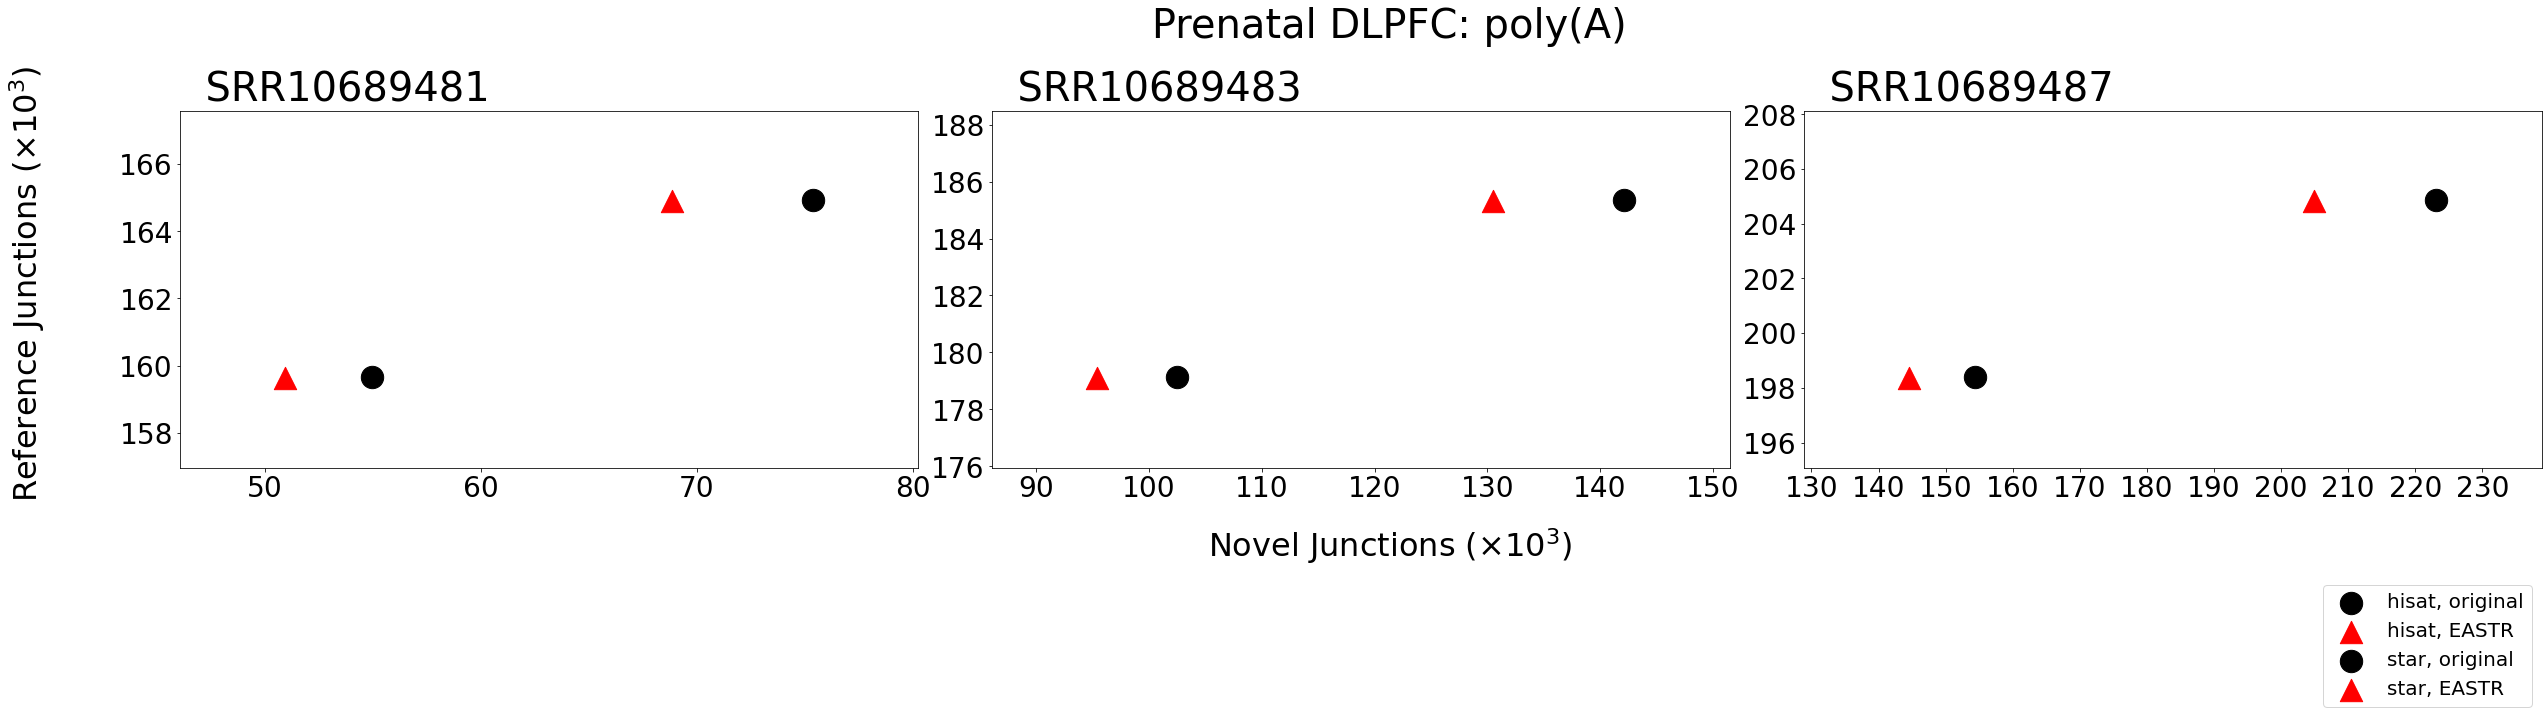

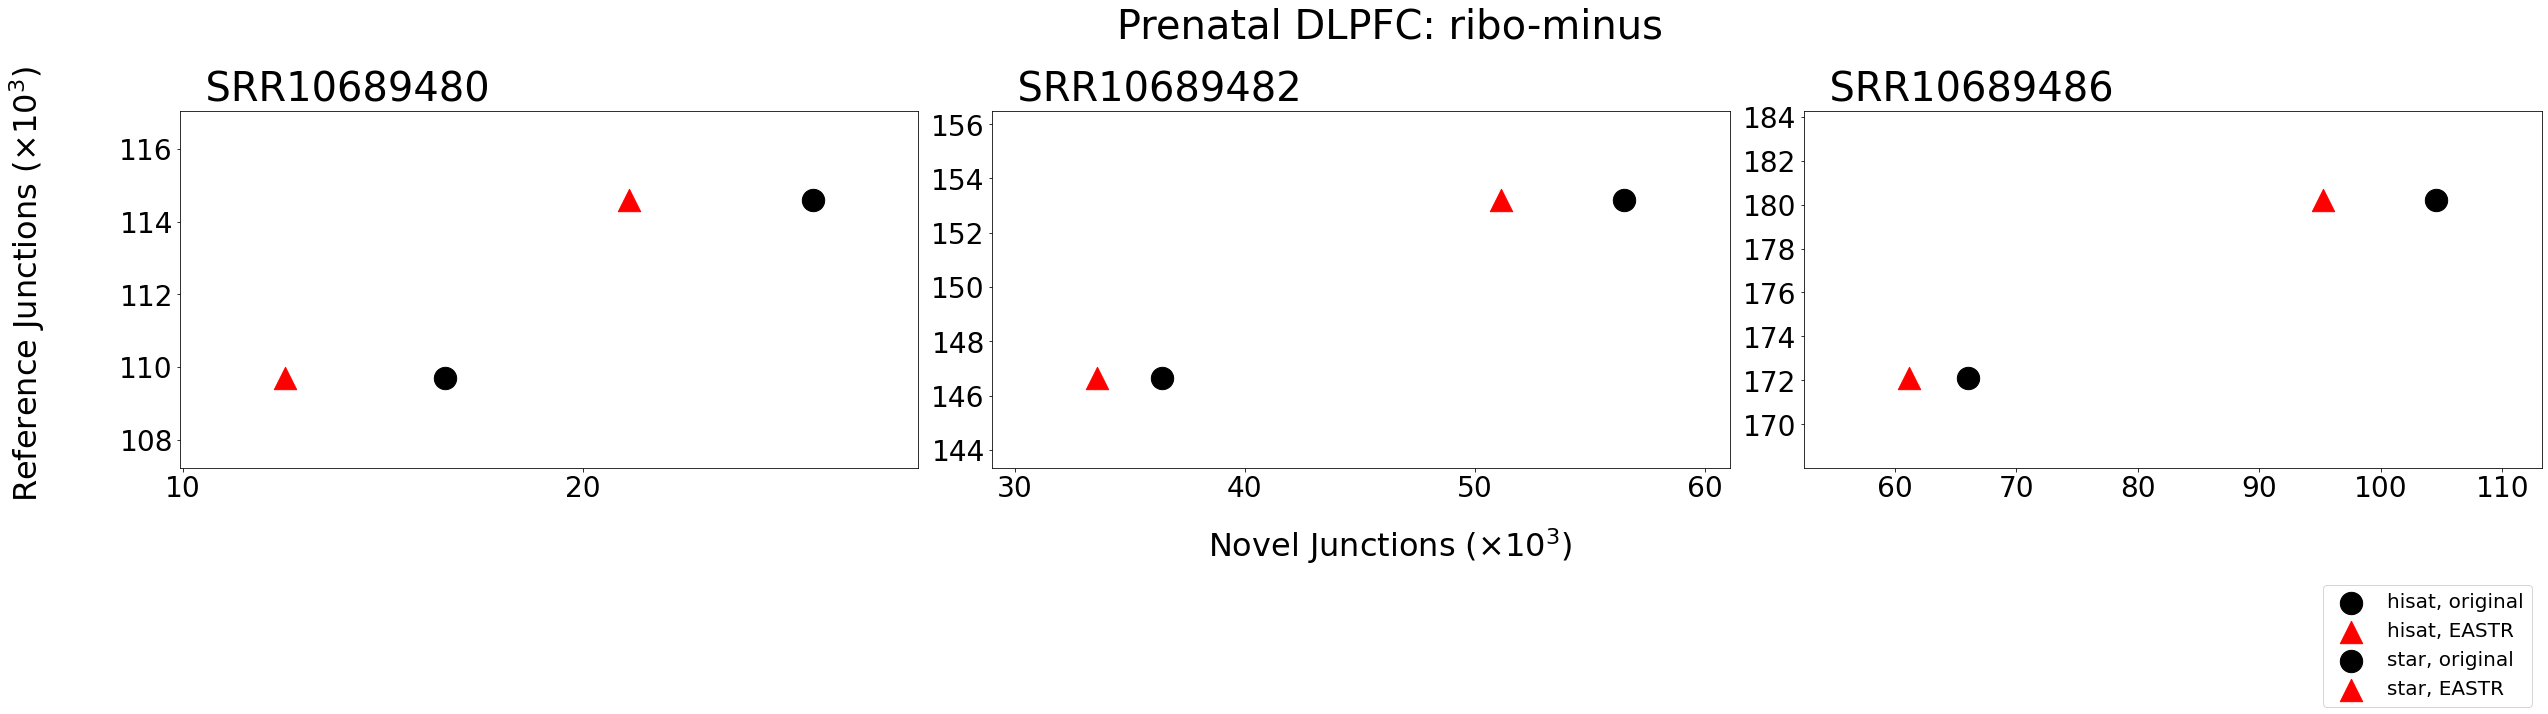

In [30]:
for i in range(0, len(info_list)):
    subplot_targets(junction_stats, info_list[i], axis_info)
    plt.savefig(os.path.join(outdir, info_list[i]["comparison"] + ".png"))
    plt.show()
    plt.close()